In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../src/")
import utils as ut
import fBm_stats as fbs
from fLe_twobath import fle_twobath
import plot_utils as pu

plt.style.use("plot_style.mplstyle")

Missing colon in file 'plot_style.mplstyle', line 17 ('axes.spines.right = True')


# SOLUTIONS

In [2]:
data_path = "../_raw/two_baths/"

In [3]:
# Next-guess algorithm
def inspect_nga(H, N, id):
    return ut.read_hdf5_data(f"{data_path}two_baths-h-{H}-{N}-{id}.hdf5")

In [4]:
# Finite differences
def inspect_fd(H, N, T, id):
    path_H = (f"{data_path}fBM-h-{H}-{N}-{id}.hdf5")
    path_12 = (f"{data_path}fBM-h-0.5-{N}-{id}.hdf5")
    noise_path = (f"{data_path}two_baths-h-{H}-noise{N}-{id}.hdf5")
    
    BH = ut.read_hdf5_data(path_H)
    B12 = ut.read_hdf5_data(path_12)
    B = np.array(BH.deets_v) + np.array(B12.deets_v)
    
    dBH = ut.read_hdf5_data(noise_path)
    
    t = dBH.deets_t
    
    delta_t = T/N
    
    eq = fle_twobath(H)
    eq.params(T, h = delta_t, v0 = 0)
    eq.external_B(B, t)
    eq.solve()
    eq.get_analytical(relaxation_type = 1)
    
    return eq

In [5]:
def plot_comparison(H, N, T, id, ax, panel,
                    color_fd, color_ng, color_a = "black",
                    xlabel = False, ylabel = False,
                    legend_main = False, legend_second = False):
    nga = inspect_nga(H, N, id)
    eq = inspect_fd(H, N, T, id)
    
    if legend_main:
        order = 2-2*H
        rorder = round(order, 1)
        if order < 0.1:
            rorder = round(order, 2)
        ax.plot(eq.t, eq.numerical, ls = "-", color = color_fd, label = r"$\alpha$ ="+str(rorder))
    else:
        ax.plot(eq.t, eq.numerical, ls = "-", color = color_fd)
        
    if legend_second:
        ax.plot(nga.deets_t, nga.deets_v, ls = "--", color = color_ng, label = "Next-guess algorithm")   
        ax.plot(eq.t, eq.analytical, ls = ":", color = color_a, label = "Analytical")
    else:
        ax.plot(nga.deets_t, nga.deets_v, ls = "--", color = color_ng)
        ax.plot(eq.t, eq.analytical, ls = ":", color = color_a)
                
    if ylabel:
        ax.set_ylabel(r"$x(t)$")
    if xlabel:
        ax.set_xlabel(r"$t$")
    pu.add_caption_letter(ax, panel)
    ax.legend()

In [6]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

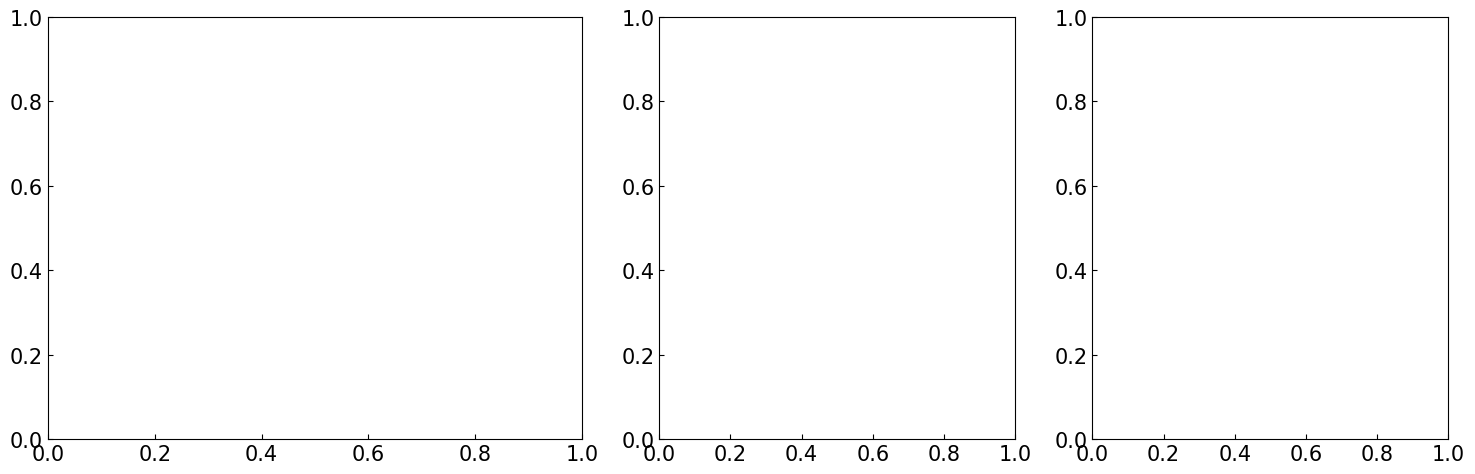

In [7]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharex = False, gridspec_kw={'width_ratios': [1.5, 1, 1]});

In [8]:
T = 20
axi = ax[0]

H = 0.99
N = 280
T = 20
id = 6
print(H)
plot_comparison(H, N, T, id, axi, 
                color_fd = colors[9],
                color_ng = colors[1],
                panel = "", ylabel = True)

H = 0.9
N = 280
T = 20
id = 5
print(H)
plot_comparison(H, N, T, id, axi, 
                color_fd = colors[8],
                color_ng = colors[1],
                panel = "", ylabel = True)

H = 0.8
N = 280
T = 20
id = 4
print(H)
plot_comparison(H, N, T, id, axi, 
                color_fd = colors[7],
                color_ng = colors[1],
                panel = "", ylabel = True)

H = 0.7
N = 280
T = 20
id = 3
print(H)
plot_comparison(H, N, T, id, axi, 
                color_fd = colors[6],
                color_ng = colors[1],
                panel = "", ylabel = True)

H = 0.6
N = 280
T = 20
id = 2
print(H)
plot_comparison(H, N, T, id, axi, 
                color_fd = colors[5],
                color_ng = colors[1],
                panel = "", ylabel = True,
                legend_second = True)

axi.set_xlim(xmin = 0, xmax = 17.5)
axi.set_ylim(ymin = -2.3, ymax = 2.3)

axi.legend(loc = "lower center")

axi.set_xlabel("Time "+r"$t$")
axi.set_ylabel("Position "+r"$x(t)$")

pu.add_caption_letter(axi, "(a)")


0.99


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.6


# MSD EQUILIBRIUM

In [9]:
data_path = "../_raw/"
h = 0.05
T = 100
n = int(T/h)
t = np.arange(0, T, h)

In [10]:
def get_msd(A, eta, C, theta_12, theta_H, H, avg = 12000, h = 0.05, task_set = ["001"]):
    for i, tk in enumerate(task_set):
        f = f"trj-set{tk}-avg{avg}-dt{h}-T{T}-A{A}-eta{eta}-C{C}-t12_{theta_12}-tH{theta_H}-H{H}"
        if i == 0:
            df_trj = ut.read_hdf5_data(data_path + f + ".hdf5")
            df_trj = df_trj.set_index("t")
        else:
            df_temp = ut.read_hdf5_data(data_path + f + ".hdf5")
            df_temp = df_temp.set_index("t")
            df_trj = pd.concat([df_trj, df_temp], axis = 1)
    msd = fbs.msd(df_trj, False).reset_index()
    msd.columns = ["t", "msd"]
    return msd

def plot_msd(ax, df_msd, H, color, log = False, order = False, analytical = False, legend_main = False, legend_second = False):
    if order:
        order = 2 - 2*H
        rorder = round(order, 1)
        if order < 0.1:
            rorder = round(order, 3)
        label = r"$\alpha$"+ f" = {rorder}"
    else:
        label = f"H = {round(H,2)}"
    if legend_main:
        df_msd.set_index("t").msd.plot(ax = ax, label = label, ls = "-", color = color)
    else:
        df_msd.set_index("t").msd.plot(ax = ax, label = "", ls = "-", color = color)
    if analytical:
        if legend_second:
            df_msd.set_index("t").msd.plot(ax = ax, label = "Analytical", ls = ":", color = "black")
        else:
            df_msd.set_index("t").msd.plot(ax = ax, label = "", ls = ":", color = "black")
    ax.legend()
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
    
def add_trend(ax, x0, xf, func, text, xtext = False, dx = 0, dy = 0, **kwargs):
    t = np.arange(x0,xf,0.01)
    if xtext:
        xloc = xtext
    else:
        xloc = xf
    if kwargs:
        ax.plot(t,func(t, H = kwargs["H"]), color = "black", alpha = 0.5, ls = ":")
        ax.text(xloc + dx, func(xloc, H = kwargs["H"]) + dy, text)
    else:
        ax.plot(t, func(t), color = "black", alpha = 0.5, ls = ":")
        ax.text(xloc + dx, func(xloc) + dy, text)

def t(t):
    return t

def t2(t):
    return t**2

def t3(t):
    return t**3

def constant(t):
    return 10 -t+t

def t2_2H(t, **kwargs):
    H = kwargs["H"]
    return t**(2-2*H)

In [11]:
avg = 12000
task_set = ["001", "002"]
A = 1.0
eta = 1.0
C = 1.0
theta_H = 1.0
theta_12 = 1.0
x0i = 1

axi = ax[1]

#TREND

H = 0.98
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(axi, df_msd, H, color = colors[9], order = True, analytical = True, legend_second = True)

H = 0.9
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(axi, df_msd, H, color = colors[8], order = True, analytical = True)

H = 0.8
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(axi, df_msd, H, color = colors[7], order = True, analytical = True)

H = 0.7
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(axi, df_msd, H, color = colors[6], order = True, analytical = True)

H = 0.6
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(axi, df_msd, H, color = colors[5], order = True, analytical = True)

axi.set_xscale("log")
axi.set_yscale("log")
axi.set_xlim(xmin = h, xmax = 100)

axi.legend(loc = "lower center")

axi.set_ylabel("MSD " r"$\langle x^2 (t) \rangle$")
axi.set_xlabel("Time "+"$t$")

pu.add_caption_letter(axi, "(b)")

In [12]:
A = 1.0
eta = 1.0
C = 0.0
theta_H = 1.0
theta_12 = 1.0

x0i = 1

axi = ax[2]

#TREND

H = 0.98
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(axi, df_msd, H, color = colors[9], order = True, legend_main = True)
add_trend(axi, x0 = x0i, xf = 100, func = t2_2H, text = r"", xtext = 0.1, H = H)
add_trend(axi, x0 = x0i, xf = 100, func = t2_2H, text = r"~$t^{\alpha}$", xtext = 30, dy = -0.7, H = H)

H = 0.9
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(axi, df_msd, H, color = colors[8], order = True, legend_main = True)
add_trend(axi, x0 = x0i, xf = 100, func = t2_2H, text = r"", xtext = 0.1, H = H)

H = 0.8
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(axi, df_msd, H, color = colors[7], order = True, legend_main = True)
add_trend(axi, x0 = x0i, xf = 100, func = t2_2H, text = r"", xtext = 0.1, H = H)

H = 0.7
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(axi, df_msd, H, color = colors[6], order = True, legend_main = True)
add_trend(axi, x0 = x0i, xf = 100, func = t2_2H, text = r"", xtext = 0.1, H = H)

H = 0.6
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(axi, df_msd, H, color = colors[5], order = True, legend_main = True)

axi.set_xscale("log")
axi.set_yscale("log")
axi.set_xlim(xmin = h, xmax = 100)
axi.set_ylim(ax[1].get_ylim())

axi.legend()

axi.set_ylabel("MSD " r"$\langle x^2 (t) \rangle$")
axi.set_xlabel("Time "+"$t$")

add_trend(axi, x0 = h, xf = 100, func = t, text = "~t", xtext = 0.1)
add_trend(axi, x0 = h, xf = 1, func = t2, text = "~t²", xtext = 0.1)
add_trend(axi, x0 = h, xf = 1, func = t3, text = "~t³", xtext = 0.1)

pu.add_caption_letter(axi, "(c)")
handles, labels = axi.get_legend_handles_labels()
axi.get_legend().remove()

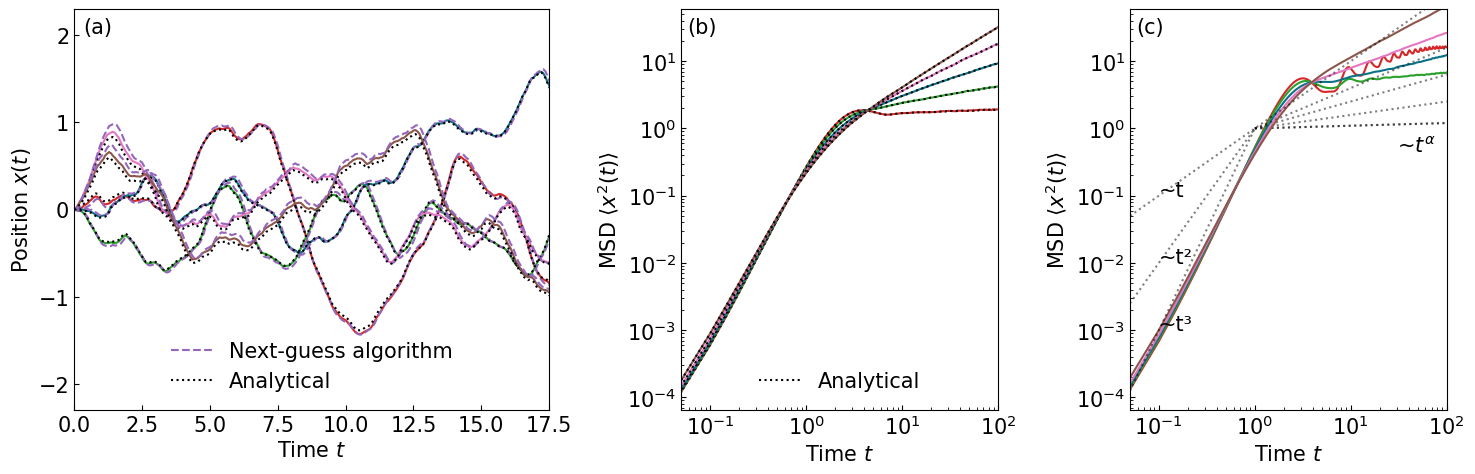

In [13]:
fig

In [14]:
fig.legend(handles, labels, bbox_to_anchor = (0.8, 1.1), ncol = 5)
fig.tight_layout()

In [15]:
fig.savefig("../outs/fig1.png", dpi = 200)
fig.savefig("../outs/fig1_500dpi.png", dpi = 500)
fig.savefig("../outs/fig1_1000dpi.png", dpi = 1000)